<a href="https://colab.research.google.com/github/ondraperny/BI-BPR-2019/blob/master/MURA_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mura dataset
Currently for testing purposes, just part of dataset is used. Specifically XR_HUMERUS data.

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import keras.backend as k
from google.colab import drive
drive.mount('/content/drive')
from keras.preprocessing.image import ImageDataGenerator
import os
from glob import glob
%matplotlib inline

PATH="/content/drive/My Drive/SKOLA/Bachelor_work/XR_HUMERUS/"

IMG_SIZE=(224,224)
BATCH_SIZE = 8

train_batches = ImageDataGenerator().flow_from_directory(
    PATH + 'train',      # this is the target directory
    target_size=IMG_SIZE,  # all images will be resized to 224*224
    batch_size=BATCH_SIZE,
)

valid_batches = ImageDataGenerator().flow_from_directory(
    PATH + 'valid',      # this is the target directory
    target_size=IMG_SIZE,  # all images will be resized to 224*224
    batch_size=BATCH_SIZE, 
)

print(train_batches.class_indices)
print(train_batches.class_indices)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 1272 images belonging to 2 classes.
Found 288 images belonging to 2 classes.
{'train_negative': 0, 'train_positive': 1}
{'train_negative': 0, 'train_positive': 1}


## Functions
Next block contains definitions of function for following code.

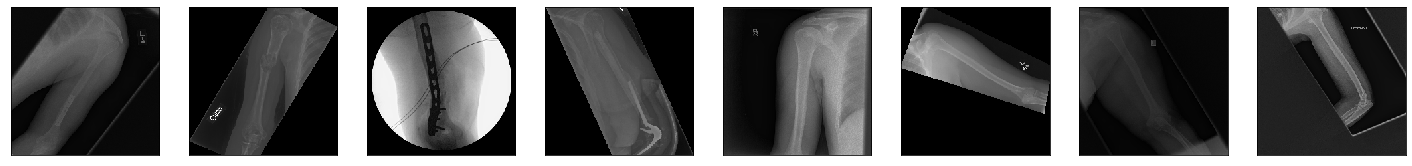

In [41]:
def show_sample_images():
  images, _ = train_batches.next()
  plt.figure(figsize=(25,25))
  for i in range(BATCH_SIZE):
    plt.subplot(1,BATCH_SIZE,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i].astype('uint8'), cmap=plt.cm.binary)
  plt.show()

def prep_images():
  ...

def model_def():
  ...


show_sample_images()

In [19]:
model = keras.Sequential([
  keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224,224,3)),
  keras.layers.Flatten(),
  keras.layers.Dense(2, activation='softmax'),
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [0]:
model.fit_generator(train_batches,
                    steps_per_epoch=62,
                    validation_data = valid_batches,
                    validation_steps = 62,
                    epochs = 5)

Epoch 1/5
62/62 [==============================] - 23s 367ms/step - loss: 5.9815 - acc: 0.6290 - val_loss: 8.3190 - val_acc: 0.4839
Epoch 2/5
62/62 [==============================] - 32s 513ms/step - loss: 7.2791 - acc: 0.5484 - val_loss: 9.0989 - val_acc: 0.4355
Epoch 3/5
62/62 [==============================] - 35s 559ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 6.7592 - val_acc: 0.5806
Epoch 4/5
62/62 [==============================] - 33s 537ms/step - loss: 7.7991 - acc: 0.5161 - val_loss: 7.0192 - val_acc: 0.5645
Epoch 5/5
62/62 [==============================] - 29s 466ms/step - loss: 7.2791 - acc: 0.5484 - val_loss: 7.2791 - val_acc: 0.5484
